### PSI Hyperspectral Data Processing Pipeline

Authors:
- Saswat Panda
- Timothy Brown


In [1]:
!pip install -r requirements.txt

In [15]:
import os
import sys
import cv2
import json
import time
import fnmatch

import requests
from urllib.parse import unquote, urlparse
import re  # Import the regular expressions module

# import open3d as o3d
import copy
import glob
import argparse
import tqdm
from natsort import natsorted
from scipy.spatial.transform import Rotation as R

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
%matplotlib inline
# JUST TO MAKE SURE SOME WARNINGS ARE IGNORED 
import warnings
warnings.filterwarnings("ignore")
import zipfile

__Select your dataset:__<br>
* If you are using a local file, enter the full path to the folder below under _"dataset_path_or_url"_
* If you want to download a file from a url, enter the URL in _"dataset_path_or_url"_
* Downloaded zipped datasets will be put in the _"/data/"_ folder unless you change the _"data_folder"_ path below


In [16]:
#dataset_path_or_url = 'https://figshare.com/ndownloader/files/15226139'
dataset_path_or_url = 'https://phenocam.anu.edu.au/cloud/a_data/_Transfer/Misc/test-psi-hyperspec-data.zip'
# dataset_path_or_url = 'data/APPF-hyperspec-sample-data-drought'

In [17]:
# Set the dataset URL and download folder
dataset_path_or_url

# Change this if you want the data to go to a different path:
data_folder = "data" 

# Make sure the download folder exists
os.makedirs(data_folder, exist_ok=True)

# Start a session and download the file
with requests.get(dataset_path_or_url, stream=True) as r:
    r.raise_for_status()
    
    # Try to extract the filename from the Content-Disposition header
    cd = r.headers.get('content-disposition')
    if cd:
        filenames = re.findall('filename="?(.+?)"?$', cd)
        if len(filenames) > 0:
            filename = filenames[0]
    else:
        # If no Content-Disposition header, extract the filename from the URL
        filename = os.path.basename(urlparse(r.url).path)
    
    # Decode URL-encoded filenames
    filename = unquote(filename).replace('"', '')  # Remove any surrounding quotes
    
    # Define the download path
    download_path = os.path.join(data_folder, filename)
    
    # Write the file to the specified directory with the extracted name
    with open(download_path, 'wb') as f:
        for chunk in r.iter_content(chunk_size=8192):
            f.write(chunk)

print(f"File downloaded to: /{download_path}")
dataset_path = download_path

# Assuming download_path is defined and contains the path to your downloaded file
if download_path[-4:].lower() == '.zip':
    print("\nThis file appears to be zipped, if so, run the code below to unzip it")
else:
    print("The downloaded dataset does not appear to be a zip file. Make sure this is the case or rename it and then unzip it.")

File downloaded to: /data/test-psi-hyperspec-data.zip

This file appears to be zipped, if so, run the code below to unzip it


In [18]:
print(download_path)

data/test-psi-hyperspec-data.zip


Use the code below to unzip the dataset if needed

In [19]:
# Check if the downloaded file is a zip file
if dataset_path.endswith('.zip'):
    response = input("The downloaded file is a zip file. Do you want to unzip it? (y/n): ")
    if response.lower() == 'y':
        with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
            zip_ref.extractall(data_folder)
        print("File unzipped successfully.")
    else:
        print("File not unzipped.")
        


The downloaded file is a zip file. Do you want to unzip it? (y/n):  y


File unzipped successfully.


In [21]:
#update dataset path to be the unzipped folder
dataset_path = dataset_path.split('.zip')[0]
print(dataset_path)

data/test-psi-hyperspec-data


In [22]:
from custom_lib.hyperspectral import HyperspectralImage
from custom_lib.utils import *

In [23]:
# set header to 16 bits
def update_line(l):
    if l.strip() == 'NBITS 12':
        return 'NBITS 16\n'
    return l


def update_hdr_file(path):
    with open(path, 'r') as f:
        lines = f.readlines()

    lines = [update_line(l) for l in lines]

    with open(path, 'w') as f:
        f.writelines(lines)

In [34]:
for path in tqdm.tqdm(glob.glob(os.path.join(dataset_path, '**', '*.hdr'), recursive=True)):
    update_hdr_file(path)

100%|██████████| 5/5 [00:00<00:00, 819.30it/s]


In [25]:
def hypMask(file_name):
    img = cv2.imread(file_name)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    mask = cv2.inRange(hsv, (38, 25, 25), (68, 255,255))
    
    ## slice the green
    imask = mask>0
    green = np.zeros_like(img, np.uint8)
    green[imask] = img[imask]
    
    # Convert the 'green' image to grayscale to make it single channel
    th = cv2.cvtColor(green, cv2.COLOR_BGR2GRAY)

    # Set the grayscale values to 255 where mask is >0
    th[th > 0] = 255
    
    kernel = np.ones((2,2),np.uint8)

    # Apply opening operation
    th = cv2.morphologyEx(th, cv2.MORPH_OPEN, kernel)
       
    return th

def hypMaskCI(file_name):
    img = cv2.imread(file_name)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    mask = cv2.inRange(hsv, (38, 25, 25), (68, 255,255))
    
    ## slice the green
    imask = mask>0
    masked = np.zeros_like(img, np.uint8)
    masked[imask] = img[imask]
    
    # Convert the 'green' image to grayscale to make it single channel
    th = cv2.cvtColor(masked, cv2.COLOR_BGR2GRAY)

    # Set the grayscale values to 255 where mask is >0
    th[th > 0] = 255
    
    
    kernel = np.ones((2,2),np.uint8)

    # Apply opening operation
    th = cv2.morphologyEx(th, cv2.MORPH_OPEN, kernel)
    
    return th, img, masked

(385, 500, 3)


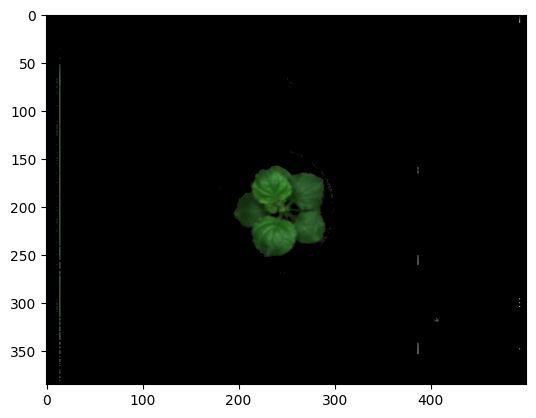

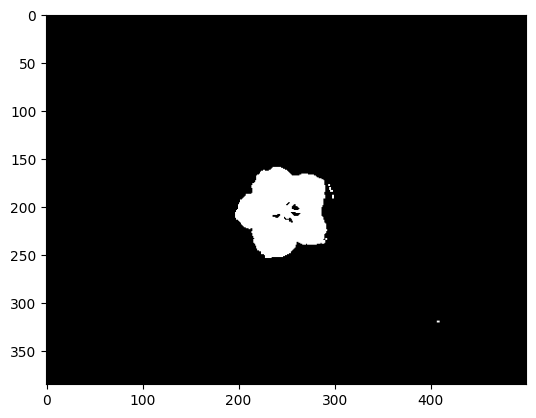

In [26]:
# List all files in the folder
files = os.listdir(dataset_path)

# Filter out files that end with '.png'
png_files = [file for file in files if file.endswith('.png')]

# Sort the list in case the files are not in the desired order
png_files.sort()

first_png_file = png_files[0]
img_path = os.path.join(dataset_path, first_png_file)

img = cv2.imread(img_path)


## convert to hsv
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

## mask of green (36,25,25) ~ (86, 255,255)
# mask = cv2.inRange(hsv, (36, 25, 25), (86, 255,255))
mask = cv2.inRange(hsv, (38, 25, 25), (68, 255,255))
# mask = cv2.inRange(hsv, (40, 107, 110), (86, 255,255))
## slice the green
imask = mask>0
green = np.zeros_like(img, np.uint8)
green[imask] = img[imask]

print(np.shape(green))

## save 
plt.imshow(cv2.cvtColor(green, cv2.COLOR_BGR2RGB))  # Use 'cmap' if your image is grayscale
plt.show()



# Convert the 'green' image to grayscale
green_1ch = cv2.cvtColor(green, cv2.COLOR_BGR2GRAY)

# Set the grayscale values to 0 where mask is 0
# green_1ch[mask == 0] = 0

# Set the grayscale values to 255 where mask is >0
green_1ch[green_1ch > 0] = 255

kernel = np.ones((2,2),np.uint8)

# Apply opening operation
green_1ch = cv2.morphologyEx(green_1ch, cv2.MORPH_OPEN, kernel)

# Display the resulting single-channel image
plt.imshow(green_1ch, cmap='gray')  # Use 'cmap' if your image is grayscale
plt.show()

In [27]:

col_names = ['tray_id', 'NDVI', 'NPCI', 'PSRI', 'NDRE', 'CCCI', 'PRI']

traits_dict = {key:[] for key in col_names}

Number of Trays (plants) used': 3
['data/test-psi-hyperspec-data/2023-05-25_16-42-52.png', 'data/test-psi-hyperspec-data/2023-05-25_16-43-20.png', 'data/test-psi-hyperspec-data/2023-05-25_16-43-48.png']
['data/test-psi-hyperspec-data/2023-05-25--16-42-16_round-0_cam-1_calibFrame.hdr', 'data/test-psi-hyperspec-data/2023-05-25--16-42-22_round-0_cam-1_calibFrame.hdr']
3
2
white: data/test-psi-hyperspec-data/2023-05-25--16-42-16_round-0_cam-1_calibFrame
dark: data/test-psi-hyperspec-data/2023-05-25--16-42-22_round-0_cam-1_calibFrame
img_path data/test-psi-hyperspec-data/2023-05-25--16-42-52_round-0_cam-1_tray-Tray_1


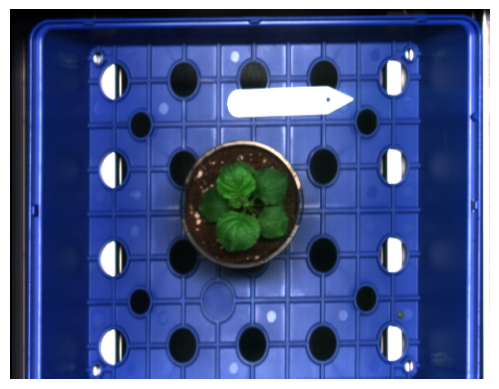

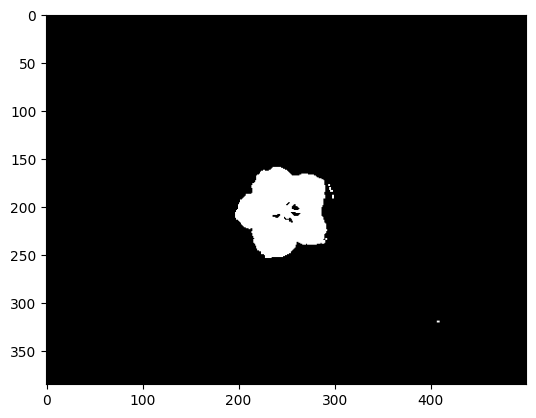

Error fixed


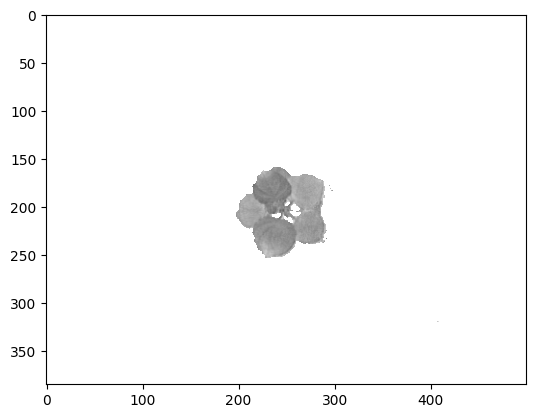

Average of all pixels in NDRE:  0.20389980832940552
Minimum value:  0.0
Maximum value:  0.43342113561578355
img_path data/test-psi-hyperspec-data/2023-05-25--16-43-20_round-0_cam-1_tray-Tray_2


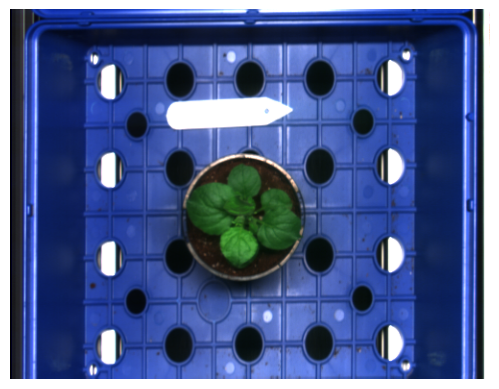

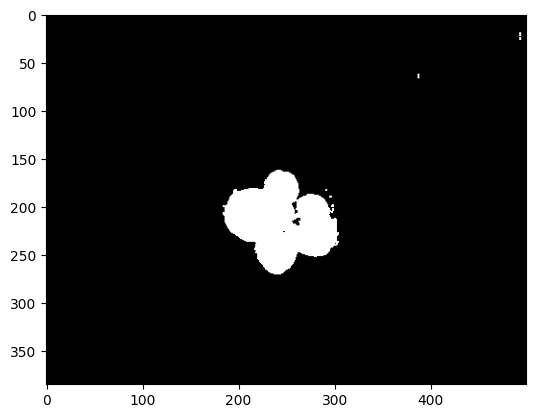

Error fixed


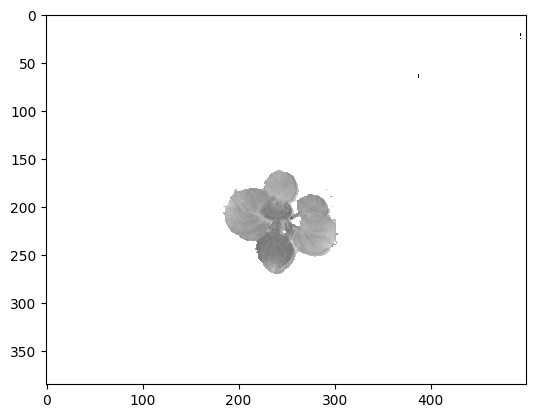

Average of all pixels in NDRE:  0.20995991496086108
Minimum value:  -0.17398600107961507
Maximum value:  0.42087721409124274
img_path data/test-psi-hyperspec-data/2023-05-25--16-43-48_round-0_cam-1_tray-Tray_3


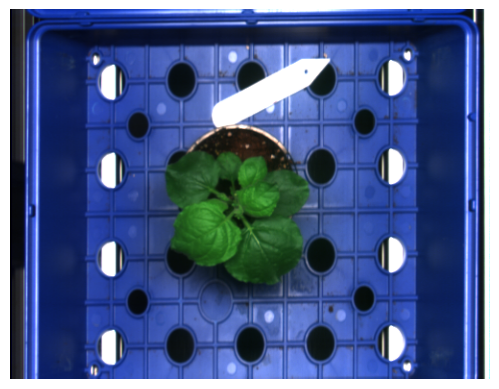

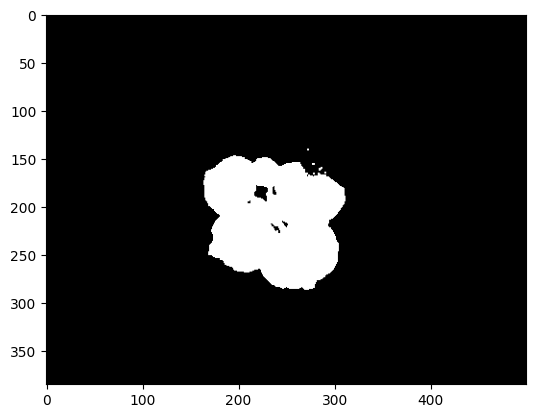

Error fixed


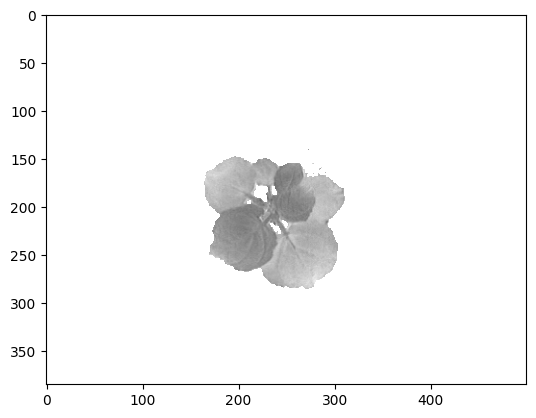

Average of all pixels in NDRE:  0.2276044594369553
Minimum value:  0.0
Maximum value:  0.4386039508707056
success


In [35]:
# List all files in the folder
files = os.listdir(dataset_path)

# Filter out files that match the pattern '-Tray_*.bil'
pattern = '*-Tray_*.bil'
tray_bil_files = [file for file in files if fnmatch.fnmatch(file, pattern)]

no_t = len(tray_bil_files)  # Prevents negative values

print(f"Number of Trays (plants) used': {no_t}")

root_path = dataset_path

img_i = 0
cf_i = 0
const_HypImg = '_round-0_cam-1_tray-Tray_'
all_img_path = natsorted(glob.glob(os.path.join(root_path, '*.png'),recursive=False)) # make it true for multiple batches
print(all_img_path)
all_calib_file = natsorted(glob.glob(os.path.join(root_path, '*_round-0_cam-1_calibFrame.hdr'),recursive=False)) # make it true for multiple batches
print(all_calib_file)

l_imgs = len(all_img_path)
print(len(all_img_path))
print(len(all_calib_file))

for i in range(int(l_imgs/no_t)):
    if (img_i == l_imgs - 1):
        break
    # Extract base name without extension for white_calib and dark_calib 
    # Combine with root_path
    white_calib = os.path.join(root_path, os.path.splitext(os.path.basename(all_calib_file[i]))[0])
    dark_calib = os.path.join(root_path, os.path.splitext(os.path.basename(all_calib_file[i+1]))[0])
    
    print('white:', white_calib)
    print('dark:', dark_calib)
    
    for k in range(0,no_t):
        hyperspec_reference_path = all_img_path[img_i]
        tmp = os.path.splitext(os.path.basename(hyperspec_reference_path))[0].split('_')
        tmp = '--'.join(tmp)
        hyperspec_image_path = os.path.join(root_path, tmp+const_HypImg+str(k+1))
        print('img_path', hyperspec_image_path)
        image_hyperspec = HyperspectralImage(hyperspec_image_path, white_calib, dark_calib)
        calib_layers = image_hyperspec.extract_all_layers()

        hyper = calib_layers[1].astype(np.float64)
        wavelength = calib_layers[0]

        #           mask used for all traits
        th_ind = hypMask(hyperspec_reference_path)
        
        th_ind, img, masked = hypMaskCI(hyperspec_reference_path)
        
        # Display the resulting single-channel image
        # cv2.imshow("img_thresh", th_ind)
        # cv2.waitKey(0)
        # cv2.destroyAllWindows()
        
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Now display the image in RGB format
        plt.imshow(img_rgb)
        plt.axis('off')  # Optional: Hide axes for a cleaner image display
        plt.show()
        
        plt.imshow(th_ind, cmap='gray')  # Use 'cmap' if your image is grayscale
        plt.show()


        # Checking for possible errors and fixing
        minWavelength = hyper[:, :, 0]
        masked_minWave = cv2.bitwise_and(minWavelength, minWavelength, mask = th_ind)
        avg_minWave = np.sum(masked_minWave)/np.count_nonzero(th_ind)

        maxWavelength = hyper[:, :, len(wavelength)-1]
        masked_maxWave = cv2.bitwise_and(maxWavelength, maxWavelength, mask = th_ind)
        avg_maxWave = np.sum(masked_maxWave)/np.count_nonzero(th_ind)

        if avg_minWave > avg_maxWave: # starting from 27 DAS
            hyper = 1 - hyper
            print("Error fixed")
            
        ind_name = "_NDRE"
        index, _ = get_ndre(hyper, wavelength)
        masked_ind = cv2.bitwise_and(index, index, mask = th_ind)
        # Display the resulting single-channel image
        # cv2.imshow("index_thresh", masked_ind)
        # cv2.waitKey(0)
        # cv2.destroyAllWindows()
        
        masked_array = np.ma.masked_where(~th_ind, masked_ind)
        plt.imshow(masked_array, cmap='gray', vmin = -0.1, vmax = 0.4)  # Use 'cmap' if your image is grayscale
        plt.show()
        
        print('Average of all pixels in NDRE: ',np.sum(masked_ind)/np.count_nonzero(th_ind))
        print('Minimum value: ', np.min(masked_ind))
        print('Maximum value: ',np.max(masked_ind))
        
        tmp_values = []
#             first add sid
        tmp_values.append(img_i)
        
#             NDVI
        index, _ = get_ndvi(hyper, wavelength)
        masked_ind = cv2.bitwise_and(index, index, mask = th_ind)
        # tmp_values.append(np.average(masked_ind)) # np.mean and np.average are same without parameters in average
        tmp_values.append(np.sum(masked_ind)/np.count_nonzero(th_ind)) # np.average(masked_ind[np.where(th_ind ==  255)])


#             NPCI
        index, _ = get_npci(hyper, wavelength)
        masked_ind = cv2.bitwise_and(index, index, mask = th_ind)
        tmp_values.append(np.sum(masked_ind)/np.count_nonzero(th_ind))

#             PSRI
        index, _ = get_psri(hyper, wavelength)
        masked_ind = cv2.bitwise_and(index, index, mask = th_ind)
        tmp_values.append(np.sum(masked_ind)/np.count_nonzero(th_ind))

#             NDRE
        index, _ = get_ndre(hyper, wavelength)
        masked_ind = cv2.bitwise_and(index, index, mask = th_ind)
        tmp_values.append(np.sum(masked_ind)/np.count_nonzero(th_ind))

#             CCCI
        index, _ = get_ccci(hyper, wavelength)
        masked_ind = cv2.bitwise_and(index, index, mask = th_ind)
        tmp_values.append(np.sum(masked_ind)/np.count_nonzero(th_ind))


#             PRI
        index, _ = get_pri(hyper, wavelength)
        masked_ind = cv2.bitwise_and(index, index, mask = th_ind)
        tmp_values.append(np.sum(masked_ind)/np.count_nonzero(th_ind))
        
        #    insert the values of the particular row one by one to dict
        for i in range(0,len(col_names)):
            traits_dict[col_names[i]].append(tmp_values[i])
        
            
        #             increase the image iterator
        img_i += 1
    
    #             increase the calibfile iterator
    cf_i += 2
    print('success')
    


In [36]:
df_hypIndex = pd.DataFrame(traits_dict)
df_hypIndex.head()

,tray_id,NDVI,NPCI,PSRI,NDRE,CCCI,PRI
0,0,0.774743,0.032154,-0.137577,0.203900,0.357609,0.010444
1,1,0.782462,-0.000264,-0.142710,0.209960,0.449835,0.015034
2,2,0.810398,-0.015063,-0.143398,0.227604,0.472507,0.019205


In [37]:
df_hypIndex.to_csv('./HypIndices.csv',index=False)